# Lecture 4: Applications of Bayesian statistics and inference

#### This notebook was developed by [Zeljko Ivezic](http://faculty.washington.edu/ivezic/) for the 2023/24 data science class at the Rudjer Boskovic Institute, and it is available from [github](https://github.com/ivezic/IRB2023/blob/main/notebooks/IRBclass3.ipynb).

Note: this notebook contains code developed by Z. Ivezic, M. Juric, A. Connolly, B. Sippocz, Jake VanderPlas, G. Richards, and many many others.

##### Resources for this notebook include:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.  
 

<a id='toc'></a>

## This notebook includes:

[Simple parameter estimation examples](#example)

[Bayesian model selection](#MSintro)

[Simple model selection examples](#MSexample)

[For overachievers: ABC and Hierarchical Bayes](#ABCandHB)

## Simple parameter estimation examples <a id='example'></a>
[Go to top](#toc)

### Parameter estimation for the binomial distribution

* We already talked about this example in Lecture 2!

If you flip a coin $N$ times and get $k$ tails, the probability of tails, $b$,
can be estimated as $b_o=k/N$. 
For large N, the uncertainty of $b_o$ is approximately Gaussian and given by 
$$ \sigma_b = \left[\frac{b_o \, (1-b_o)}{N}\right]^{1/2}. $$

For small N, we can use Bayesian approach to compute posterior pdf $p(b)$, as follows.

Here the data set $\{x_i\}$ is discrete: all outcomes are either 0 (heads) or 1 (tails, which we will consider “success”). An astronomical analog might be the computation of the fraction of galaxies which show evidence for a black hole in their center. 

Given a model parametrized by the probability of success (i.e. tails) $b$, the likelihood that the data set 
contains k outcomes equal to 1 is given by 
  $$    p(k\,|\,b, N) = \frac{N!}{k! \, (N-k)!} \, b^k \, (1-b)^{N-k} $$

Assuming that the prior for $b$ is flat in the range 0-1, the posterior pdf for $b$ is
$$ p(b \,|\, k, N ) = C \, b^k \, (1-b)^{N-k}, $$

where the normalization constant $C$ can be determined from the condition $\int_0^1 p(b\,|\,k,N)\, db = 1$.

For a concrete numerical example, let us assume that we studied $N = 10$ galaxies and found 
a black hole in $k = 4$ of them. Our best estimate for the fraction of galaxies with black 
holes is $b_o = k/N = 0.4$. An interesting question is, “What is the probability that, say, 
$b < 0.1$?”. For example, your colleague’s theory placed *an upper limit of 10%* for the fraction 
of galaxies with black holes and you want to test this theory using classical framework 
“Can it be rejected at a confidence level $\alpha = 0.01$?”.

In other words, if the probability of $b < 0.1$, given data, is smaller than 0.01 (that is,
the probability of $b > 0.1$ is larger than 0.99) we reject the theory (in classical statistical 
hypothesis testing), and if the probability of $b < 0.1$ is larger than 0.01 we cannot reject
the theory (which does not prove that the theory is correct!). We will address Bayesian
hypothesis testing (i.e. model selection) further below. 

In [1]:
import numpy as np
from scipy.stats import norm, binom
from matplotlib import pyplot as plt

In [24]:
# modeled after code by Jake VanderPlas:
# https://www.astroml.org/book_figures/chapter5/fig_posterior_binomial.html
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)

def doBinomial(n=10, k=4, CDFmin=1E-3):
    
    import numpy as np
    from scipy.stats import norm, binom
    from matplotlib import pyplot as plt

    #------------------------------------------------------------
    # Plot posterior as a function of b
    # n = 10  # number of points
    # k = 4  # number of successes from n draws

    b = np.linspace(0, 1, 100)
    db = b[1] - b[0]

    # compute the probability p(b) (eqn. 5.70)
    p_b = b ** k * (1 - b) ** (n - k)
    p_b /= p_b.sum()
    p_b /= db
    cuml_p_b = p_b.cumsum()
    cuml_p_b /= cuml_p_b[-1]

    # compute the gaussian approximation (eqn. 5.71)
    b0 = k * 1. / n
    sigb = np.sqrt(b0*(1-b0)/n)
    p_g = norm(b0, sigb).pdf(b)
    cuml_p_g = p_g.cumsum()
    cuml_p_g /= cuml_p_g[-1]

    #------------------------------------------------------------
    # Plot the results
    fig = plt.figure(figsize=(9, 5))
    fig.subplots_adjust(left=0.11, right=0.95, wspace=0.35, bottom=0.18)

    ax = fig.add_subplot(121)
    ax.plot(b, p_b, '-b')
    ax.plot(b, p_g, '--r')
    expVal = k/n 
    ax.plot([expVal, expVal], [1E-6, 2000], ':k')

    ax.set_ylim(-0.05, np.max(p_b)*1.1)

    ax.set_xlabel('$b$')
    ax.set_ylabel('$p(b|n,k,I)$')
    plt.title('blue: exact; red: Gaussian approximation')

    ax = fig.add_subplot(122, yscale='log')
    ax.plot(b, cuml_p_b, '-b')
    ax.plot(b, cuml_p_g, '--r')
    ax.plot([expVal, expVal], [1E-3, 2], ':k')
    ax.plot([-0.02, 1.02], [0.5, 0.5], ':k')

    titleStr = 'cumulative pdf'
    plt.title(titleStr)

    ax.set_xlabel('$b$')
    ax.set_ylabel('$P(<b|n,k,I)$')
    ax.set_ylim(CDFmin, 2)
    
    print('n =', n, 'k =', k, ': CDF(b=0.1)=', np.interp(0.1, b, cuml_p_b))

    plt.show()

n = 10 k = 4 : CDF(b=0.1)= 0.003425489725149792


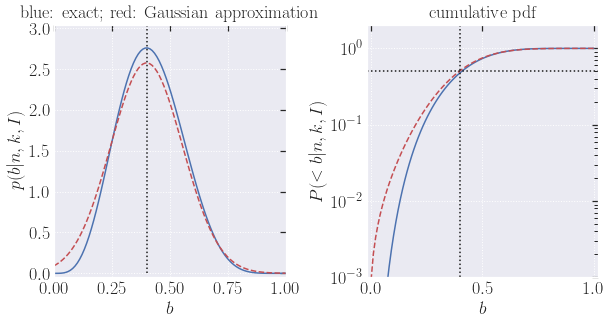

In [25]:
doBinomial(10, 4)

### Parameter estimation for the binomial distribution

For $N=10$ and $k=4$: $p(b < 0.1\,|\,k = 4, N = 10) = 0.0034$ and the theory is rejected
at a confidence level $\alpha = 0.01$. 

However, using Gaussian approximation we get 
$p(b < 0.1) = 0.03$ and thus at a confidence level $\alpha = 0.01$ the theory is **not** rejected! 

**Conclusion**: when $N$ is not large, or $b_o$ is close to 0 or 1, one should avoid using the 
Gaussian approximation when estimating the credible region (or the confidence interval) for $b$.

An interesting numerical experiment is to observe how $p(b \,|\, k, N )$ evolves with the number
and outcome of coin flips...

Here, experiment with the above code by changing $k$ and $N$ and observing the bahavior of $p(b)$, and its (dis)agreement with the Gaussian approximation. 

n = 100 k = 40 : CDF(b=0.1)= 3.27307714807364e-15


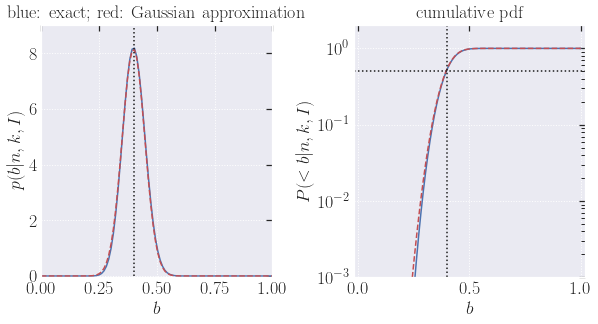

In [28]:
doBinomial(100, 40)

## It is interesting to see how the posterior changes with each data point:

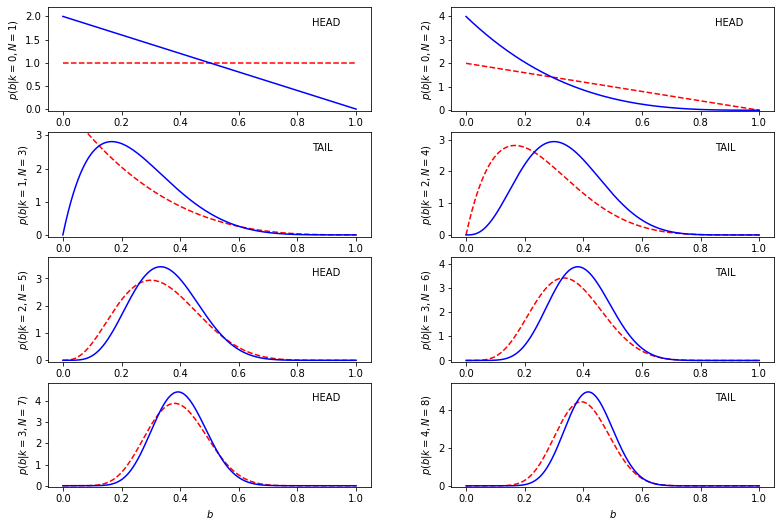

p(b<0.25):  0.011894078069101604


In [4]:
# results for my coin (0:head, 1: tail)
flipData = [0, 0, 1, 1, 0, 1, 0, 1]

# plotting setup 
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.25, bottom=0.18)
 
# b grid for computing p(b) 
b = np.linspace(0,1,1000)
db = b[1]-b[0]
# prior 
p_b = 1.0 + 0*b   # flat prior
# p_b = norm(0.5, 0.1).pdf(b)   Gaussian prior

# loop over data
for i in range(1,9):
    ax = fig.add_subplot(int('52' + str(i)))
    # show p_b before this data point is added
    ax.plot(b, p_b, '--r')
    # now get new p_b
    N = i 
    k = flipData[0:i].count(1)
    p_b = p_b * (b ** k * (1 - b) ** (N - k))
    p_b /= p_b.sum()
    p_b /= db
    # p_b after this data point is added
    label=' z'
    ax.plot(b, p_b, '-b', label=label)
    ax.set_xlabel('$b$')
    s = '$p(b|k=%i' % k
    s = s + ', N=%i)$' % N
    if (flipData[i-1] == 0): 
        ax.text(0.85, np.max(p_b)*0.9,'HEAD')
    else:
        ax.text(0.85, np.max(p_b)*0.9,'TAIL')
    ax.set_ylabel(s)
    ax.set_ylim(-0.05, np.max(p_b)*1.1)
    
plt.show()

cuml_p_b = p_b.cumsum()
cuml_p_b /= cuml_p_b[-1]
print('p(b<0.25): ', np.interp(0.25, b, cuml_p_b)) 




# Bayesian model selection <a id='MSintro'></a>
[Go to top](#toc)

## Bayesian Statistical Inference

In Bayesian inference, we evaluate the **posterior probability** by using
** data likelihood** and **prior** information: 
 
$$p(M,\theta \,|\,D,I) = \frac{p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I)}{p(D\,|M,\,I)},$$

The prior can be expanded as 
$$p(M,\theta\,|\,I) = p(\theta\,|\,M,I)\,p(M\,|\,I).$$
 
It is often the case that **the evidence** $p(D\,|M,\,I)$ is not evaluated explictly since the posterior probability 
can be (re)normalized. 

Using the law of total probability, recall
$$p(A) = \sum_ip(A|B_i)p(B_i),$$
we can evaluate the evidence as 
$$E(M) = p(D\,|M,\,I) = \int p(D\,|\,M, \theta, I) \, p(\theta\,|M,\,I) \, d\theta$$

**The Bayesian Statistical Inference process** is then
* formulate the likelihood, $p(D\,|\,M,\theta,I)$
* chose a prior $p(M,\theta\,|\,I)$, which incorporates *other information beyond the data in $D$*
* determine the posterior pdf, $p(M,\theta \,|\,D,I)$
* search for the model parameters that maximize $p(M,\theta \,|\,D,I)$ 
* quantify the uncertainty of the model parameter estimates (credible region)
 
 
### Bayesian Model Comparison

To determine which model is better we compute the ratio of the posterior probabilities or the **odds ratio** for two models as
$$O_{21} \equiv \frac{p(M_2|D,I)}{p(M_1|D,I)}.$$

The posterior probability that the model $M$ is correct given data $D$, $p(M|D,I)$,  is given by the Bayes rule,
$$p(M|D,I) = \frac{p(D|M,I)p(M|I)}{p(D|I)},$$
and the odds ratio can ignore $p(D|I)$ since it will be the same for both models. 

We get 
$$O_{21} = \frac{p(D\,|\,M_2,I)\,p(M_2\,|\,I)}{p(D\,|\,M_1,I)\,p(M_1\,|\,I)} \equiv B_{21} \, \frac{p(M_2\,|\,I)}{p(M_1\,|\,I)},$$
where $B_{21}$ is called the **Bayes factor**. 

The Bayes factor compares how well the models fit the data: it is a ratio of data likelihoods averaged over 
all allowed values of the model parameters and computed as (again, using the law of total probability)
$$B_{21} = \frac{\int p(D\,|\,M_2, \theta, I) \, p(\theta\,|\,M_2, I) \, d\theta}{\int p(D\,|\,M_1, \theta, I) \, p(\theta\,|\,M_1, I) \, d\theta}. $$
 
In other words, the Bayes factor is the ratio of **the global likelihoods for models $M_1$ and $M_2$**, 
where the global likelihood, or evidence, is a weighted average of the likelihood function, with the 
prior for model parameters acting as the weighting function.

N.B. To get the best-fit model parameters, we take a derivative of the product of the likelihood function
and priors with respect to model parameters (and equate it to 0), while to get the global likelihood we integrate that product (that is, the posterior) over the model parameter space.
 
**How do we interpret the values of the odds ratio, $O_{21}$, in practice?**

Jeffreys proposed a five-step scale for 
interpreting the odds ratio, where $O_{21} > 10$ represents “strong” evidence in favor of $M_2$ ($M_2$ 
is ten times more probable than $M_1$; analogously $O_{21} < 0.1$ is “strong” evidence in favor of $M_1$), 
and $O_{21} > 100$ is “decisive” evidence ($M_2$ is one hundred times more probable than $M_1$). 
When $O_{21} < 3$, the evidence is “not worth more than a bare mention.”

### Approximate Bayesian Model Comparison

The data likelihood, required to compute the models odds ratio, and the commonly 
used $\chi^2$ goodness-of-fit parameter are related. By introducting a few 
assumptions and approximations, the computations of the odds ratio can be
greatly simplified and expressed as the sum of $\chi^2$ and a term that penalizes
models for their parameters (when models achieve similar values of $\chi^2$,
the one with the smallest number of free parameters wins). 
 
We consider a one dimensional case with unknown parameter $\mu$ and
start with an approximate computation of the evidence $E(M)$,
$$ E(M) = \int p(\{x_i\}, \,|\,M, \mu, I) \, p(\mu \,|\,M, I) \, d \mu .$$

Our first assumption is that the prior is uniform 
$$  p(\mu\,|\, M, I) = \frac{1}{\Delta} \,\,\,\,\,\, {\rm for} \,\,\, -\frac{\Delta}{2} < \mu < \frac{\Delta}{2}$$
and 0 otherwise. 

The second assumption is that the data likelihood can
be approximated as a Gaussian around its maximum at $\mu=\mu_0$
$$ p(\{x_i\} \,|\,M, \mu, I) \approx L(\mu_0) \, \exp \left( - \frac{(\mu - \mu_0)^2}{2 \sigma_\mu^2} \right). $$

These assumptions lead to 
$$ E(M) \approx \frac{L(\mu_0)}{\Delta} \, \int_{-\Delta/2}^{\Delta/2} \exp \left( - \frac{(\mu - \mu_0)^2}{2 \sigma_\mu^2}\right) d\mu, $$
and with an additional assumption $\sigma_\mu \ll \Delta$ (data overcomes
the prior), we get
$$ E(M) \approx \frac{\sigma_\mu}{\Delta} \, L(\mu_0) \, \sqrt{2\pi}. $$

Note that $E(M) \ll L(\mu_0)$, because $\sigma_\mu \ll \Delta$. In multi-dimensional
case, each model parameter constrained by the model carries a similar 
multiplicative penalty, proportional to $\sigma_\mu/\Delta$, when computing the 
Bayes factor. If a parameter, or a degenerate parameter combination, is unconstrained 
by the data (i.e., $\sigma_\mu \approx \Delta$), there is no penalty.  
The odds ratio can justify an additional model parameter **only if this penalty is offset** by either 
an increase of the maximum value of the data likelihood, $L(\mu_0$), or by the ratio 
of prior model probabilities, $p(M_2|I)/p(M_1|I)$. If both of these quantities are 
similar for the two models, the one with fewer parameters typically wins.

If a model is well constrained by the data, for each of $k$ constrained
parameters, $\sigma_\mu \propto 1/\sqrt{N}$, where $N$ is the number of data 
points. Therefore,
$$ E(M) \propto L(\mu_0) \, \left(\sqrt{N}\right)^k. $$
 
In order to establish connection with $\chi^2$ via $L(\mu_0) =
\exp\left(-\frac{\chi^2}{2}\right)$, we define for a model the **Bayesian information 
criterion (BIC)** as $BIC \equiv -2\ln{E(M)}$, and finally obtain  
$${\rm BIC} = -2 \ln [L_0(M)] + k \ln N.$$ 
The 1st term on the RHS is equal to model's $\chi^2$ (under the assumption 
of normality; note that this is *not* $\chi^2$ per degree of freedom!) and 
the 2nd term on the RHS penalizes complex models relative to simple ones.

In summary, when multiple models are considered, their BIC values, computed as
$${\rm BIC} = \chi^2 + k \ln N,$$ 
where $N$ is the number of data points and $k$ is the number of constrained
model parameters, are compared and the model with the smallest BIC value wins.   
 
**N.B.** BIC is an approximation and might not be valid if the underlying 
assumptions (data ovecoming prior and Gaussian likelihood) are not met! In general, it is better to compute the odds ratio when computationally feasible.

   
###  How do we interpret BIC? 

Given the relationship between the BIC and $O_{21},$ 
$$    \Delta BIC \equiv BIC_2 - BIC_1 = -2\,\ln(O_{21}) $$ 
we have that $O_{21}=10$ corresponds to $\Delta BIC= -4.6$ and $O_{21}=100$ corresponds to $\Delta BIC = -9.2$.
For completeness, $|\Delta BIC|<2$ is “not worth more than a bare mention.”

### Bayesian Hypothesis Testing

In *hypothesis testing* we are essentially comparing a model, $M_1$, to its complement.  That is $p(M_1) + p(M_2) = 1$.  

If we take $M_1$ to be the "null" (default) hypothesis (which is generally that, for example, a correlation does *not* exist), then we are asking whether or not the data reject the null hypothesis.

In classical hypothesis testing we can ask whether or not a single model provides a good description of the data.  

** In Bayesian hypothesis testing, we must have an alternative comparison model! **


Let's draw sample from a Cauchy distribution and perform Bayesian Model Comparison for 
Cauchy and Gaussian models. 




## Simple model selection examples <a id='MSexample'></a>
[Go to top](#toc)

## Example 1:  Gaussian vs. Cauchy model 

#### Let's draw sample from a Cauchy distribution and perform Bayesian Model Comparison for Cauchy and Gaussian models.

Results for first 10 points:
  L(M = Cauchy) = 1.18e-12 +/- 5.39e-16
  L(M = Gauss)  = 8.09e-13 +/- 7.45e-16
  O_{CG} = 1.45 +/- 0.00134


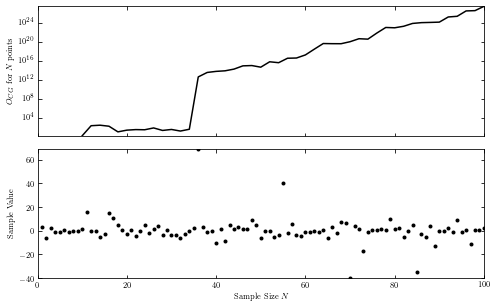

In [5]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import cauchy, norm
from scipy import integrate

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


def logL_cauchy(xi, gamma, mu,
                mu_min=-10, mu_max=10, sigma_min=0.01, sigma_max=100):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(gamma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    prior_normalization = - (np.log(mu_max - mu_min)
                             + np.log(np.log(sigma_max / sigma_min)))

    return (prior_normalization
            - n * np.log(np.pi)
            + (n - 1) * np.log(gamma)
            - np.sum(np.log(gamma ** 2 + (xi - mu) ** 2), 0))


def logL_gaussian(xi, sigma, mu,
                  mu_min=-10, mu_max=10, sigma_min=0.01, sigma_max=100):
    """Equation 5.57: gaussian likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(sigma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    prior_normalization = - (np.log(mu_max - mu_min)
                             + np.log(np.log(sigma_max / sigma_min)))

    return (prior_normalization
            - 0.5 * n * np.log(2 * np.pi)
            - (n + 1) * np.log(sigma)
            - np.sum(0.5 * ((xi - mu) / sigma) ** 2, 0))


def calculate_odds_ratio(xi, epsrel=1E-8, epsabs=1E-15):
    """
    Compute the odds ratio by perfoming a double integral
    over the likelihood space.
    """
    gauss_Ifunc = lambda mu, sigma: np.exp(logL_gaussian(xi, mu, sigma))
    cauchy_Ifunc = lambda mu, gamma: np.exp(logL_cauchy(xi, mu, gamma))

    I_gauss, err_gauss = integrate.dblquad(gauss_Ifunc, -np.inf, np.inf,
                                           lambda x: 0, lambda x: np.inf,
                                           epsabs=epsabs, epsrel=epsrel)
    I_cauchy, err_cauchy = integrate.dblquad(cauchy_Ifunc, -np.inf, np.inf,
                                             lambda x: 0, lambda x: np.inf,
                                             epsabs=epsabs, epsrel=epsrel)

    if I_gauss == 0:
        O_CG = np.inf
        err_O_CG = np.inf
    else:
        O_CG = I_cauchy / I_gauss
        err_O_CG = O_CG * np.sqrt((err_gauss / I_gauss) ** 2)

    return (I_gauss, err_gauss), (I_cauchy, err_cauchy), (O_CG, err_O_CG)


#------------------------------------------------------------
# Draw points from a Cauchy distribution
np.random.seed(44)
mu = 0
gamma = 2
xi = cauchy(mu, gamma).rvs(100)

#------------------------------------------------------------
# compute the odds ratio for the first 10 points
((I_gauss, err_gauss),
 (I_cauchy, err_cauchy),
 (O_CG, err_O_CG)) = calculate_odds_ratio(xi[:10])

print("Results for first 10 points:")
print("  L(M = Cauchy) = %.2e +/- %.2e" % (I_cauchy, err_cauchy))
print("  L(M = Gauss)  = %.2e +/- %.2e" % (I_gauss, err_gauss))
print("  O_{CG} = %.3g +/- %.3g" % (O_CG, err_O_CG))

#------------------------------------------------------------
# calculate the results as a function of number of points
Nrange = np.arange(10, 101, 2)
Odds = np.zeros(Nrange.shape)
for i, N in enumerate(Nrange):
    res = calculate_odds_ratio(xi[:N])
    Odds[i] = res[2][0]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(8, 5))
fig.subplots_adjust(hspace=0.1)

ax1 = fig.add_subplot(211, yscale='log')
ax1.plot(Nrange, Odds, '-k')
ax1.set_ylabel(r'$O_{CG}$ for $N$ points')
ax1.set_xlim(0, 100)
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_locator(plt.LogLocator(base=10000.0))

ax2 = fig.add_subplot(212)
ax2.scatter(np.arange(1, len(xi) + 1), xi, lw=0, s=16, c='k')
ax2.set_xlim(0, 100)
ax2.set_xlabel('Sample Size $N$')
ax2.set_ylabel('Sample Value')

plt.show() 

## Example 2:  Coin Flip 

Let's look at an example we already discussed: the coin flip. Let's assume we have
N draws and k are success (say, heads). 

We will compare two hypotheses; 

**M1**: the coin has a known heads probability $b_\ast$ (say, a fair coin with $b_\ast=0.5$), and 

**M2**: the heads probability $b$ is unknown, with a uniform prior in the range 0–1. 
Note that the prior for model M1 is a delta function, $\delta(b-b_\ast)$. 

Given a model parametrized by the probability of success $b$, the likelihood that the data set 
contains k outcomes equal to 1 is given by 
  $$    p(k\,|\,b, N) = \frac{N!}{k! \, (N-k)!} \, b^k \, (1-b)^{N-k} $$

For model M2 the prior for $b$ is flat in the range 0-1 and the product of the 
data likelihood and prior is same as above. However, for model M1 the prior is a 
delta function $\delta(b-b_\ast)$ and we get for the product of the 
data likelihood and prior  
$$    p(k\,|\,b_\ast, N, M1)\,p(b|M1, I) = \frac{N!}{k! \, (N-k)!} \, b_\ast^k \, (1-b_\ast)^{N-k}. $$

Consequently, the odds ratio is given by 
$$ O_{21} = \int_0^1 \left(\frac{b}{b_\ast}\right)^k \left(\frac{1-b}{1-b_\ast}\right)^{N-k} db, $$
as illustrated in the following figure. 

 
![OddsRatio](figures/odds.tiff)

This figure (from the textbook) illustrates the behavior of $O_{21}$ as a function of $k$
for two different values of N and for two different values of $b_\ast$: $b_\ast = 0.5$ 
(M1: the coin is fair) and $b_\ast = 0.1$. As the figure shows, the ability to distinguish 
the two hypothesis **improves** with the sample size. For example, when $b_\ast= 0.5$ and 
k/N = 0.1, the odds ratio in favor of M2 increases from about 9 for N = 10 to about 
263 for N = 20. When k = $b_\ast N$, the odds ratio is 0.37 for N = 10 and 0.27 for N = 20. 
In other words, **the simpler model is favored by the data**, and the support strengthens 
with the sample size. 

It is easy to show by integration of the above equation for $O_{21}$ that 
$O_{21}= \sqrt{\pi/(2N)}$ when k = $b_\ast N$ and $b_\ast = 0.5$. For example, to build strong 
evidence that a coin is fair, $O_{21} < 0.1$, it takes as many as N $>$ 157 tosses. With 
N = 10,000, the heads probability of a fair coin is measured with a precision of 1% and
the corresponding odds ratio is $O_{21} \approx 1/80$, approaching Jeffreys’ decisive 
evidence level. 
 
In **frequentist approach**, we would ask whether we can reject the null hypothesis that 
our coin is fair. We would ask whether a given $k$ is a very unusual outcome (at some 
significance level $\alpha$, say $\alpha=0.05$, which corresponds to about "2$\sigma$"
deviation) for a fair coin with $b_\ast = 0.5$ and with
a given N. In the **Bayesian approach**, we offer an alternative hypothesis that the coin 
has an unknown heads probability. While this probability can be estimated from provided 
data ($b_0$), **we consider all the possible values** of $b_0$ when comparing the two proposed 
hypotheses. 

As a numerical example, let's consider N=20 and k=16. Using the results discussed earlier, 
we find that the scatter around the expected value $k_0 = b_\ast N$ = 10 is $\sigma_k = 2.24$. 
Therefore, k = 16 is about 2.7$\sigma_k$ away from $k_0$, and at the adopted significance 
level $\alpha=0.05$ we **reject the null hypothesis** (this rejection means that it is unlikely that k = 16 would have arisen by chance). Of course, k = 16 does **not** imply 
that it is impossible that the coin is fair (infrequent events happen, too!).

As shown in the above figure, the chosen parameters (N=20 and k=16) correspond to the 
Bayesian **odds ratio** of about 10 in favor of hypothesis M2.  


### Approximate Bayesian Model Comparison

Let's now use BIC to address the same problem and illustrate how model M2 gets 
penalized for its free parameter. Essentially, we want an approximation for the
integral expression for $O_{21}$
$$ O_{21} = \int_0^1 \left(\frac{b}{b_\ast}\right)^k \left(\frac{1-b}{1-b_\ast}\right)^{N-k} db, $$
 
We can approximate 
$$ E(M2) \approx \sqrt{2\pi} \, L(b_0) \, \sigma_b, $$
where $b_0 = k/N$ and for largish N we have $\sigma_b \approx \sqrt{b_0(1-b_0)/N}$. 

For M1, we have exact result because the prior is $\delta$ function
$$ E(M1) = \frac{N!}{k! \,(N-k)!} b_\ast^k (1-b_\ast)^{N-k}.$$

And the odds ratio becomes
$$ O_{21} \approx \sqrt{2\pi} \, \sigma_b \,
\left(\frac{b_0}{b_\ast}\right)^k \left(\frac{1-b_0}{1-b_\ast}\right)^{N-k} =
\sqrt{2\pi}\, \sqrt{\frac{b_0(1-b_0)}{N}} \, \left(\frac{b_0}{b_\ast}\right)^k \left(\frac{1-b_0}{1-b_\ast}\right)^{N-k} .$$

Now we can explicitly see that the evidence in favor of model M2 decreases (the model is “penalized”) proportionally to the posterior pdf width of its free parameter, $\sigma_b$. 

If indeed $b_0 \approx b_\ast$, model M1 wins because it explained the data without
any free parameter. On the other hand, the evidence in favor of M2 increases as the 
data-based value $b_0$ becomes very different from the prior $b_\ast$ claimed by model M1:
**model M1 becomes disfavored because it is unable to explain the observed data.**






## Example 3: use BIC to find the best polynomial model for a given dataset

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # set default plot styles
from scipy import stats
from scipy import optimize

# this function computes polynomial models given some data x
# and parameters theta
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, x, y, sigma_y, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(degree, x, y, sigma_y, model=polynomial_fit):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(theta, x, y, sigma_y, model)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

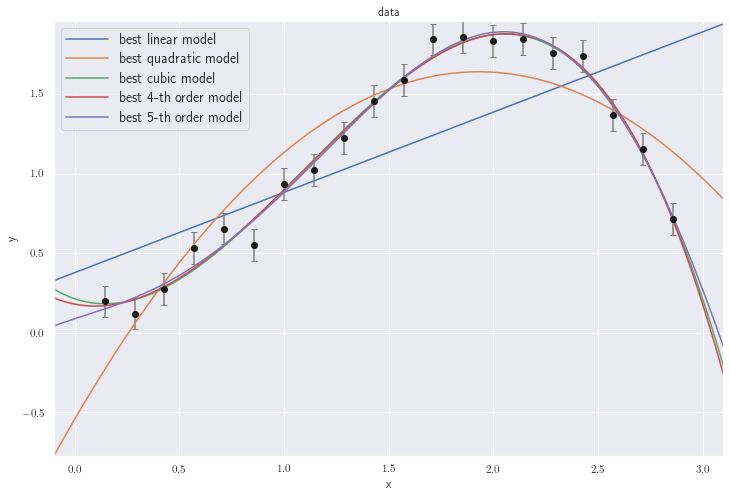

In [7]:
# generate (noisy) data
np.random.seed(0)
Ndata = 22
x = np.linspace(0, 3, Ndata)[1:-1]
sigma_y = 0.1 + 0*x
y = np.random.normal(np.sin(x) * x, sigma_y) 
# data = np.array([x, y, sigma_y])

# get best-fit parameters for linear, quadratic and cubic models
theta1 = best_theta(1, x, y, sigma_y)
theta2 = best_theta(2, x, y, sigma_y)
theta3 = best_theta(3, x, y, sigma_y)
theta4 = best_theta(4, x, y, sigma_y)
theta5 = best_theta(5, x, y, sigma_y)


# generate best fit lines on a fine grid 
xfit = np.linspace(-0.1, 3.1, 1000)
yfit1 = polynomial_fit(theta1, xfit)
yfit2 = polynomial_fit(theta2, xfit)
yfit3 = polynomial_fit(theta3, xfit)
yfit4 = polynomial_fit(theta4, xfit)
yfit5 = polynomial_fit(theta5, xfit)


# plot 
fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(xfit, polynomial_fit(theta1, xfit), label='best linear model')
ax.plot(xfit, polynomial_fit(theta2, xfit), label='best quadratic model')
ax.plot(xfit, polynomial_fit(theta3, xfit), label='best cubic model')
ax.plot(xfit, polynomial_fit(theta4, xfit), label='best 4-th order model')
ax.plot(xfit, polynomial_fit(theta5, xfit), label='best 5-th order model')

ax.legend(loc='best', fontsize=14)
ax.set(xlabel='x', ylabel='y', title='data');

In [8]:
# compute chi2 per degree of freedom: sum{[(y-yfit)/sigma_y]^2} 
chi21 = np.sum(((y-polynomial_fit(theta1, x))/sigma_y)**2) 
chi22 = np.sum(((y-polynomial_fit(theta2, x))/sigma_y)**2) 
chi23 = np.sum(((y-polynomial_fit(theta3, x))/sigma_y)**2) 
chi24 = np.sum(((y-polynomial_fit(theta4, x))/sigma_y)**2) 
chi25 = np.sum(((y-polynomial_fit(theta5, x))/sigma_y)**2) 


# the number of fitted parameters is 2, 3, 4, 5, 6
BIC1 = chi21 + 2*np.log(Ndata)
BIC2 = chi22 + 3*np.log(Ndata)
BIC3 = chi23 + 4*np.log(Ndata)
BIC4 = chi24 + 5*np.log(Ndata)
BIC5 = chi25 + 6*np.log(Ndata)


print ("         MODEL             CHI2          BIC")
print ('    best linear model:', chi21, BIC1)
print (' best quadratic model:', chi22, BIC2)
print ('     best cubic model:', chi23, BIC3)
print ('best 4-th order model:', chi24, BIC4)
print ('best 5-th order model:', chi25, BIC5)
print ("")
print ("Therefore, the cubic model is the winner!")

         MODEL             CHI2          BIC
    best linear model: 349.65913513675673 355.84122004347336
 best quadratic model: 99.33135251840581 108.60447987848076
     best cubic model: 10.182096497819613 22.54626631125288
best 4-th order model: 10.090493156273212 25.545705423064792
best 5-th order model: 9.753601457780237 28.29985617793013

Therefore, the cubic model is the winner!


### HOWEVER, not by much - we cannot really strongly reject the 4-th order model...

## Example 4: a dataset with 4 Gaussian components 


**Gaussian mixture model** is a relatively simple and straightfoward numerical method on obtaining data likelihood function, and expectation maximization algorithm for maximizing the likelihood.  
The likelihood of a datum $x_i$ for a Gaussian mixture model is given by  

$$p(x_i|\theta) = \sum_{j=1}^{M} \alpha_{j}\mathcal{N}(\mu_j, \sigma_j)$$  

where vector of parameters $\theta$ is estimated from Gaussian with parameters $\mu_j$ and $\sigma_j$.   
$\alpha_j$ is the normalization factor for each Gaussian, with $\sum_{j=1}^{M} \alpha_{j} = 1$.   
M is given.
  
Let us introduce another metric for comparing models. Both **Akaike information criterion (AIC)** and **Bayesian information criterion (BIC)** are scoring systems for model comparisons in classical statistics dealing with models with different numbers of free parameters.  

Specifically, **AIC** is computed as

$$AIC \equiv -2 ln(L^0(M)) + 2k + \frac{2k(k+1)}{N-k-1}$$  

As we showed earlier, **BIC** is computed as

$$BIC \equiv -2ln[L^0(M)] + k lnN$$  
  
In this notebook, we are going to apply Gaussian mixture model on a dataset generated using 4 Gaussians. Then we will use AIC and BIC for model comparisons, and finally plot the best scored model in BIC.  

In [9]:
### Modeled after astroML book figure 4.2  
from sklearn.mixture import GaussianMixture as GMM
setup_text_plots(fontsize=18, usetex=True)

def doGMM(Ndata, noiseStd=0.00000001):
    #------------------------------------------------------------
    # Set up the dataset by drawing samples from Gaussians.
    #  We'll use scikit-learn's Gaussian Mixture Model to sample
    #  data from a mixture of 1-D Gaussians.  The usual way of using
    #  this involves fitting the mixture to data: we'll see that
    #  below.  Here we'll set the internal means, covariances,
    #  and weights by-hand and then generate a sample of requested 
    #  size Ndata. 
    N1 = int(0.2*Ndata)
    N2 = int(0.3*Ndata)
    N3 = int(0.2*Ndata)
    N4 = Ndata - (N1+N2+N3)
    random_state = np.random.RandomState(seed=1)
    X = np.concatenate([random_state.normal(-4, 1.1, N1),
                    random_state.normal(-1, 1.0, N2),
                    random_state.normal(0.9, 0.7, N3),
                    random_state.normal(3, 1.0, N4)]).reshape(-1, 1)
    X = np.random.normal(X, noiseStd)

    #------------------------------------------------------------
    # Learn (train) the best-fit GMM models
    # Here we'll use GMM in the standard way: the fit() method
    # uses an Expectation-Maximization approach to find the best
    # mixture of Gaussians for the data

    # fit models with 1-10 components
    N = np.arange(1, 11)
    models = [None for i in range(len(N))]
    for i in range(len(N)):
        models[i] = GMM(N[i]).fit(X)
    # compute the BIC for each model
    BIC = [m.bic(X) for m in models]

    #------------------------------------------------------------
    # Plot the results
    #  We'll use two panels:
    #   1) data + best-fit mixture
    #   2) BIC vs number of components 

    fig = plt.figure(figsize=(12, 7))
    fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


    # plot 1: data + best-fit mixture
    ax = fig.add_subplot(121)
    M_best = models[np.argmin(BIC)]

    x = np.linspace(-10, 10, 1000)
    logprob = M_best.score_samples(x.reshape(-1, 1))
    responsibilities = M_best.predict_proba(x.reshape(-1, 1))

    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    ax.hist(X, 'auto', density=True, histtype='stepfilled', alpha=0.4)
    ax.plot(x, pdf, '-k')
    ax.plot(x, pdf_individual, '--k')
    ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')

    # plot 2: BIC
    ax = fig.add_subplot(122)
    ax.plot(N, BIC, '--k')
    ax.set_xlabel('n. components')
    ax.set_ylabel('BIC')

    ibest = np.argmin(BIC)
    print(BIC[ibest-1]-BIC[ibest], BIC[ibest], BIC[ibest+1]-BIC[ibest])
    plt.show()

984.0430821691989 471778.1084615164 506.02431321394397


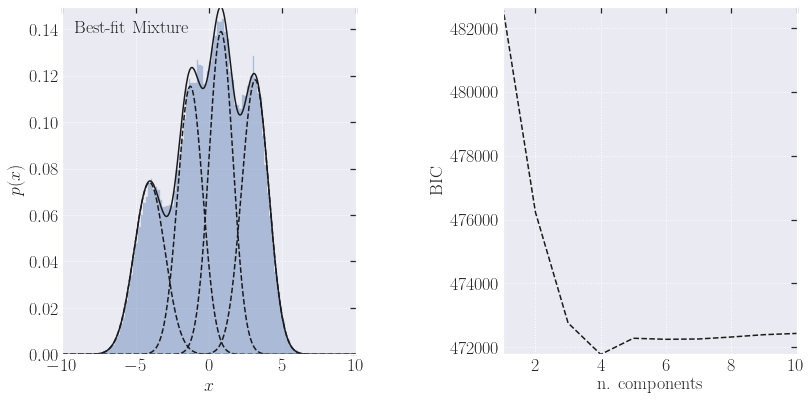

CPU times: user 4.46 s, sys: 2.52 s, total: 6.99 s
Wall time: 2.35 s


In [30]:
# let's see what we have, using a huge number of data points
%time doGMM(100000)    

Recall that $|\Delta BIC| = 5$ corresponds to “strong” evidence and $|\Delta BIC| = 10$ to “decisive” evidence.

We can conclude that the figure shows **hugely decisive** evidence in favor of the 4-component model. That is,
you should **not** argue that there are 3 peaks, or 5 peaks, in the left panel! 

What if we had a **much smaller** sample?

4.709128365183915 1448.730068815824 15.378306290623641


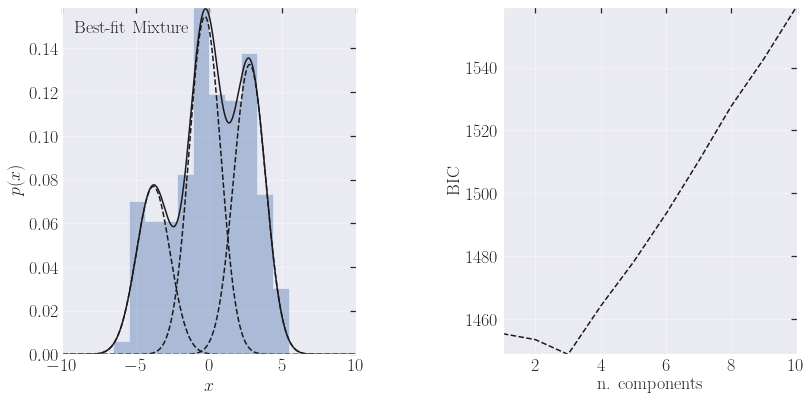

CPU times: user 535 ms, sys: 289 ms, total: 824 ms
Wall time: 308 ms


In [34]:
# what if we have a much smaller sample?
%time doGMM(300)  

##  How do we interpret BIC? 

The figure above (right panel) shows that the 3-component model has a BIC lower
by about 15 than the 4-component model. This is sufficient evidence to
claim that the 3-component model is a much better choice than the 4-component model. 

Because the sample size is small, we did not "discover" the 4th component! 

Note also that the evidence in favor of 3 components, compared to 2-component 
and single-component models is not overwhelming! 

**“not worth more than a bare mention.”**

Altough we **did** draw that dataset from a model with 4 components, a sample of 300 values is insufficient to 
*discover* more than 3 components!

What if we increase the sample size? 

###  Conclusion: large sample size helps!  
### But one more thing: let's convolve our data with an arbitrary Gaussian to simulate measurement errors. 

90.52263337701515 25367.415959767055 29.945946284969978


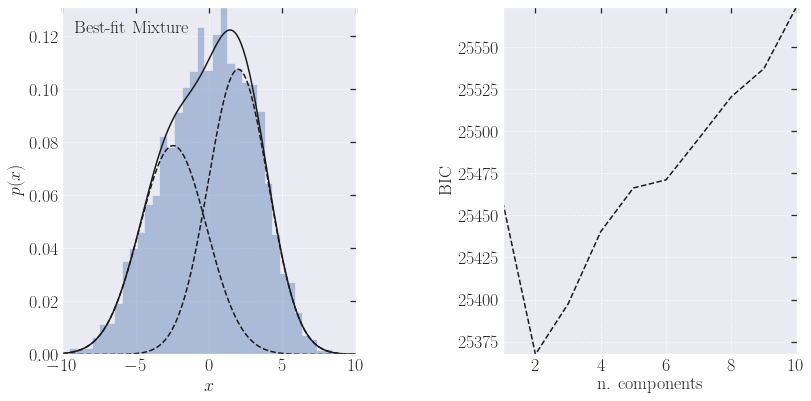

CPU times: user 931 ms, sys: 371 ms, total: 1.3 s
Wall time: 451 ms


In [13]:
%time doGMM(5000,1.5)

## **Conclusion**
### If you badly "blur" your sample, of course you will not see the fine structure (i.e. many components)! 

### Therefore, even with large samples, you still need to have precise and well calibrated  measurements!  

# For overachievers... <a id='ABCandHB'></a> 

### What can we do when it's impossible to formulate likelihood function? 

[ABC: Approximate Bayesian Computation](https://github.com/astroML/astroML-workshop_AAS235/blob/master/approximate_bayesian_computation/AAS2019_ABCexample.ipynb)


### Hierarchical Bayes Modeling

(a.k.a. multilevel models, Bayesian belief networks, or graphical models)

In hierarchical, or multilevel, Bayesian analysis a prior distribution depends on unknown variables, the hyperparameters, that describe the group (population) level probabilistic model.

Their priors, called hyperpriors, resemble the priors in simple (single-level) Bayesian models.

When there are many independent measurement sets that share same priors, they together constrain priors better than can any single measurement alone.

In statistics, this effect is known as borrowing strength and is related to the concept of shrinkage estimators.
 
 

[An examnple of Hierarchical Bayes Modeling](https://github.com/astroML/astroML-workshop_AAS235/blob/master/hierarchical_bayes/AAS2019_HBexample.ipynb)


[Go to top](#toc)